In [6]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn import metrics

In [13]:
import sys
sys.path.append('../')
from utils.models import shufflenet_model
from utils.data import SiameseDataset

In [3]:
test_data = pd.read_csv("../Data/custom/test.csv")
test_data

,0,1,2
0,071/071_11.png,071_forg/071_forg_04.png,0
1,071/071_06.png,071/071_15.png,1
2,071/071_16.png,071/071_23.png,1
3,072/072_20.png,072/072_03.png,1
4,072/072_23.png,072/072_15.png,1
...,...,...,...
5563,068/068_11.png,068/068_05.png,1
5564,072/072_22.png,072/072_01.png,1
5565,069/069_06.png,069_forg/069_forg_04.png,0
5566,073/073_05.png,073_forg/073_forg_07.png,0


In [4]:
true_labels = np.array(test_data['2'])
true_labels.shape

(5568,)

In [16]:
data = SiameseDataset('../Data/custom/test.csv', '../Data/custom/full', 224, False)
TestDataloader = DataLoader(dataset=data, batch_size=32)

In [11]:
model = shufflenet_model()
model.load_state_dict(torch.load("../Models/shufflenet.pth"))


Number of Parameters = 2,609,392


<All keys matched successfully>

In [17]:
model.to("cuda")
distances = []
model.eval()
with torch.inference_mode():
    for x1, x2, y in TestDataloader:
        x1 = x1.to("cuda")
        x2 = x2.to("cuda")
        outputs = model(x1, x2)
        distances.extend(outputs.cpu().numpy())

distances = np.array(distances)

In [5]:
distances = np.load("../Data/custom/Performance/test_performance.npy")
distances.shape

(5967,)

In [105]:
preds = distances.copy()
for i in range(len(preds)):
    if preds[i]>0.242:
        preds[i] = 0
    else:
        preds[i] = 1

In [106]:
metrics.accuracy_score(true_labels, preds)

0.9337284482758621

In [107]:
print(metrics.classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2832
           1       0.94      0.92      0.93      2736

    accuracy                           0.93      5568
   macro avg       0.93      0.93      0.93      5568
weighted avg       0.93      0.93      0.93      5568



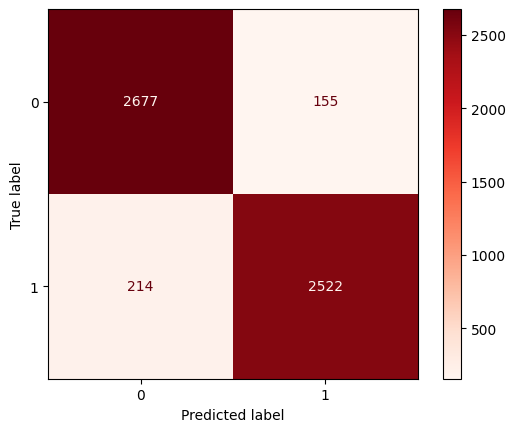

In [108]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cf = confusion_matrix(true_labels, preds)
matrix_disp = ConfusionMatrixDisplay(cf)
matrix_disp.plot(cmap='Reds')
plt.show()

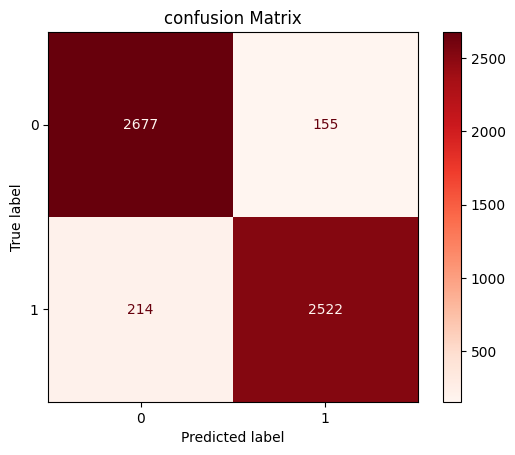

In [125]:
a = ConfusionMatrixDisplay.from_predictions(true_labels, preds, cmap='Reds')
plt.title("confusion Matrix")
plt.savefig('img.jpg', dpi=300, bbox_inches = 'tight')
plt.show()

In [128]:
report = metrics.classification_report(true_labels, preds, output_dict=True)

In [132]:
import json

with open('shufflenet_report.json', 'a') as file:
    json.dump(report, file, indent=4)